# Leandro Guerra - Outspoken Market
http://www.outspokenmarket.com

#### Ibovespa - Análise de risco com Monte Carlo

##### Quer entender mais sobre a teoria? Assista aqui
- Introdução à Simulação de Monte Carlo: https://www.youtube.com/watch?v=bpz9I1gngWI

Todas as análises produzidas aqui foram feitas com a linguagem R e dados extraídos do Yahoo Finance

In [1]:
# Importando as bibliotecas

library(quantmod)
library(tidyverse)
options(warn=-1)

Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::first()  masks xts::first()
x dplyr::lag()    masks stats::lag()
x dplyr::last()   masks xts::la

Vou selecionar os dados do Índice Bovespa do último triênio: 2017 à 2019

In [2]:
tickers <- c("^BVSP")

# Período
startdate <- as.Date("2015-01-01")
enddate <- as.Date("2019-12-31")
getSymbols(tickers, src = "yahoo", from = startdate, to = enddate)
BVSP <- data.frame(BVSP, stringsAsFactors = FALSE)
BVSP$Data <- as.Date(as.character(rownames(BVSP)))
names(BVSP) <- c("Abertura", "Maxima", "Minima", "Fechamento", "Volume", "Ajuste", "Data")

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.



[1] "^BVSP"

Agora, calculo o rertono para cada dia de pregão

In [3]:
# Calculando os retornos e o alvo

BVSP <- mutate(BVSP, Fechamento_lag = lag(Fechamento)) # vai criar um NA na primeira linha
BVSP <- na.omit(BVSP)
BVSP$Retornos <- (BVSP$Fechamento/BVSP$Fechamento_lag-1)
BVSP <- BVSP %>% select(Data, everything())

head(BVSP)

,Data,Abertura,Maxima,Minima,Fechamento,Volume,Ajuste,Fechamento_lag,Retornos
2,2015-01-05,48512,48512,47264,47517,3866100,47517,48512,-0.020510389
3,2015-01-06,47517,48061,47338,48001,4559300,48001,47517,0.010185828
4,2015-01-07,48006,49882,48006,49463,4408800,49463,48001,0.030457699
5,2015-01-08,49463,50261,49017,49943,3621900,49943,49463,0.009704223
6,2015-01-09,49955,49955,48501,48840,2999200,48840,49943,-0.022085177
7,2015-01-12,48840,48840,47956,48140,3246100,48140,48840,-0.014332514


Como o mercado se comportou nestes últimos 3 anos?
- Naturalmente, tem-se uma clara tendência de alta;
- Assim como os retornos foram normalmente distribuídos (tal qual esperado), com atenção especial ao "Joesley Day"

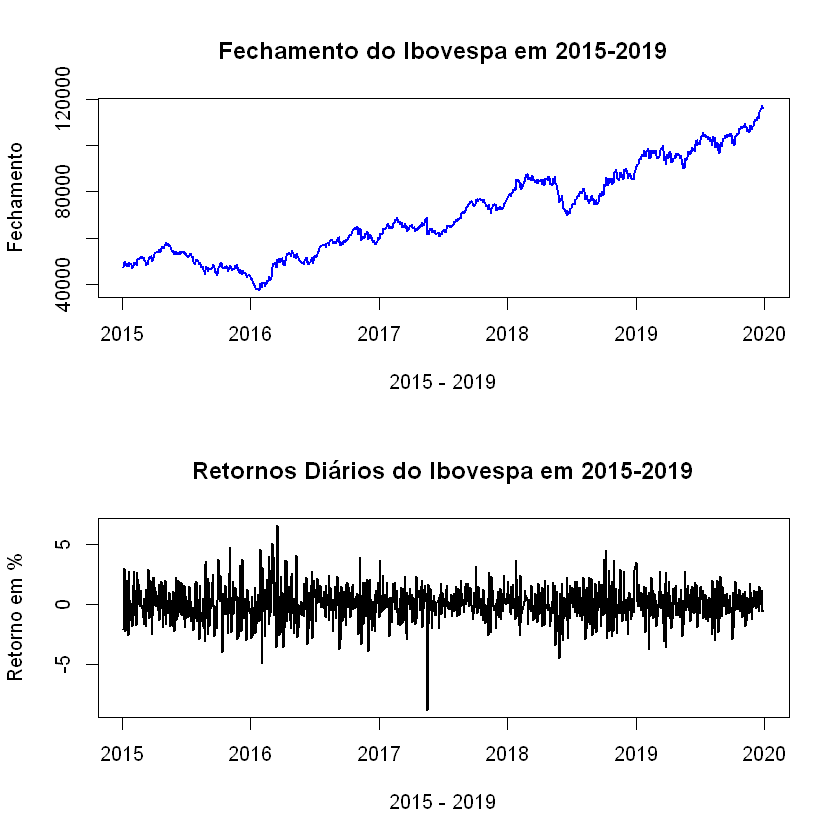

In [5]:
par(mfrow=c(2,1))
plot(BVSP$Data, BVSP$Fechamento, type = "l", col = "blue", lwd = 2,
     main = "Fechamento do Ibovespa em 2015-2019",
     xlab = "2015 - 2019",
     ylab = "Fechamento")
plot(BVSP$Data, BVSP$Retornos*100, type = "l", col = "black", lwd = 2,
     main = "Retornos Diários do Ibovespa em 2015-2019",
     xlab = "2015 - 2019",
     ylab = "Retorno em %")

# Análise de risco com Monte Carlo

Nesta etapa, vou calcular os parâmetros de entrada para a simulação de Monte Carlo
- A ideia é fazer uma projeção dos preços para os próximos 255 pregões
- A principal influência da simulação vem do desvio padrão. Aqui, insiro um valor relativamente alto (10%), pensando em acomadar os valores simulados à uma realidade de crise, onde naturalmente a volatilidade é ampliada

In [6]:
#Parametros do processo

#Retorno anual (Média de 2015/2019)
u <- ((last(BVSP$Fechamento)/first(BVSP$Fechamento))-1)/5

#Desvio padrão anual hipotético - 10%
sd <- 0.1

# Parâmetro de tempo
periodo <- 1:256
anos <- 5

A próxima etapa apresenta o cálculo dos valores simulados, totalizando 100,000 simulações

In [7]:
# Simulações
n_sim <- 100000
total_sim <- matrix(0, nrow = 256, ncol = n_sim)
p_inicial <- last(BVSP$Fechamento)      

for(j in 1:n_sim){
  aux <- 2
  p <- p_inicial # Preço inicial
  preco <- c(p) # Vetor para acumular os precos ao longo do tempo
  dist <- rnorm(255,0,1) # Distribuição normal, 255 valores, com média 0 e desvio p. 1
  for(i in dist)
  {
    P = p + p*(u/255 + sd/sqrt(255)*i)
    preco[aux] <- P                        
    p = P                                 
    aux = aux + 1
  }
  total_sim[,j] <- preco
}         

#### Visualização das Simulações

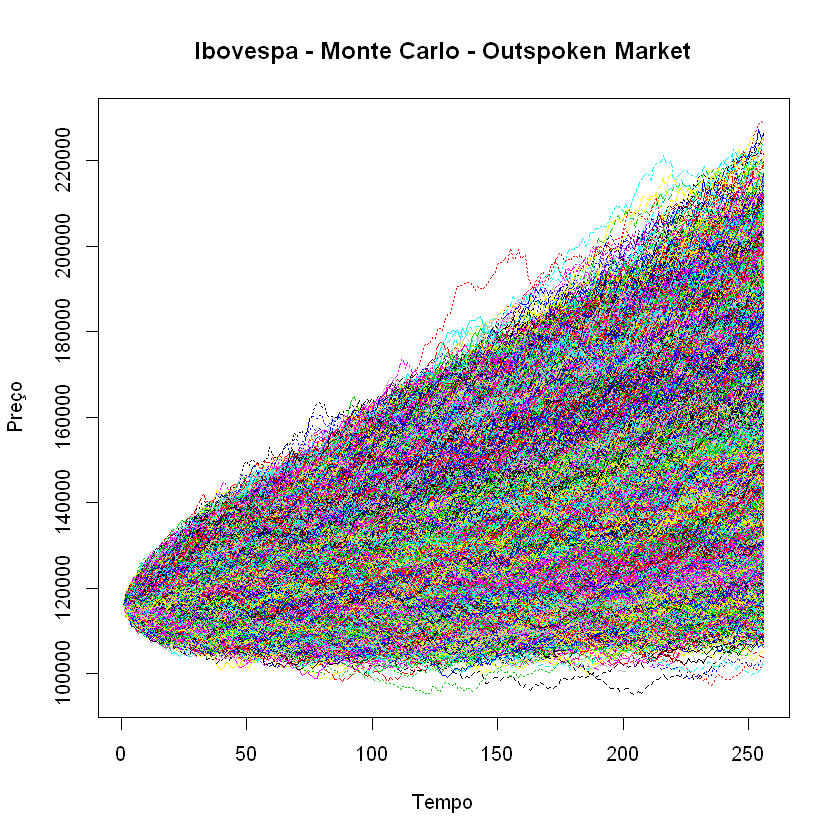

In [8]:
matplot(total_sim
        , main = "Ibovespa - Monte Carlo - Outspoken Market"
        , xlab = "Tempo"
        , ylab = "Preço"
        , type = "l"
        , col = 1:n_sim)

Qual é chance de termos preços em zonas específicas?

In [9]:
round(quantile(total_sim, probs = c(0.05,0.95)), 2)

5%      95% 
115534.2 162644.4

Disto, tem-se que 5% dos preços simulados são menores que 115,534.17 pontos e 95% estão abaixo de 162,644.37

E qual é o valor mínimo das 100,000 simulações?

In [10]:
round(min(total_sim),2)

[1] 95088.39

Calculando o Value at Risk - VaR

In [11]:
round((1-p_inicial/quantile(total_sim, probs = c(0.01, 0.05)))*100, 2)

1%    5% 
-3.27 -0.37

Estes resultados indicam uma perda (dia) de -3.27% ou mais com 1% de probabilidade ou -0.37% ou mais com 5% de probabilidade